<h1 style="text-align:center;font-size:30px;" > Quora Question Pair Similarity Continued </h1>

### Notebook - 2

In [2]:
# First things first
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# libraries for preprocessing
import re
from bs4 import BeautifulSoup
import nltk
#nltk.download("wordnet")
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import distance
from PIL import Image
import requests

In [4]:
# Importing saved i.e preprocessed dataset from last notebook

data = pd.read_csv("1_featured_data_set_without_clean.csv")
data.head(2)


,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3


## 1] Data preprocessing and cleaning

In [5]:
# Just randomly checking for unwanted characters symbols etc
list(data.question1.head(10))

['What is the step by step guide to invest in share market in india?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'Why am I mentally very lonely? How can I solve it?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 'Should I buy tiago?',
 'How can I be a good geologist?',
 'When do you use シ instead of し?',
 'Motorola (company): Can I hack my Charter Motorolla DCX3400?']

In [5]:
list(data.question2.head(10))

['What is the step by step guide to invest in share market?',
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
 'How can Internet speed be increased by hacking through DNS?',
 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?',
 'Which fish would survive in salt water?',
 "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",
 'What keeps childern active and far from phone and video games?',
 'What should I do to be a great geologist?',
 'When do you use "&" instead of "and"?',
 'How do I hack Motorola DCX3400 for free internet?']

### What need's to be Preprocessed:
    - Html tags 
    - Punctuations
    - Performing stemming
    - Stopwords
    - Contractions
    - Special characters etc

In [7]:
# Saving stopwords
stopwords = set(STOPWORDS)
stopwords.remove('no') #removing negation from tweets as they contribute a lot
stopwords.remove('nor')
stopwords.remove('not')

In [8]:
# contractions set for expanding contractions
contraction = { "ain't": "is not","aren't": "are not","'re": " are","can't": "cannot","can't've": "cannot have",
"'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have","didn't": "did not",
"doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not",
"'ve": " have","he'd": "he would","he'd've": "he would have","he'll": "he will","he'll've": "he will have","he's": "he is",
"how'd": "how did","how'd'y": "how do you","how'll": "how will","how's": "how is","I'd": "I had","I'd've": "I would have","I'll": "I will",
"I'll've": "I will have","I'm": "I am","I've": "I have","isn't": "is not","it'd": "it would","it'd've": "it would have",
"it'll": "it will","it'll've": "it will have","it's": "it is","i'm":"i am","i've": "i have","i'd": "i had","let's": "let us",
"ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not","mightn't've": "might not have","must've": "must have",
"mustn't": "must not","mustn't've": "must not have","needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
"oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she had",
"she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is","should've": "should have",
"shouldn't": "should not","shouldn't've": "should not have","so've": "so have","so's": "so is","that'd": "that would","that'd've": "that would have",
"that's": "that is","there'd": "there would","there'd've": "there would have","there's": "there is","they'd": "they had","they'd've": "they would have",
"they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have","to've": "to have",
"wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are",
"we've": "we have","weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are",
"what's": "what is","what've": "what have","when's": "when is","when've": "when have","where'd": "where did","where's": "where is",
"where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is","who've": "who have","why's": "why is",
"why've": "why have","will've": "will have","won't": "will not","won't've": "will not have","would've": "would have",
"wouldn't": "would not","wouldn't've": "would not have","y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have",
"y'all're": "you all are","y'all've": "you all have","you'd": "you would","you'd've": "you would have","you'll": "you will",
"you'll've": "you will have","you're": "you are","you've": "you have"
}

In [9]:
# function's for cleaaning questions
def contractions(text):
    contract_removed = []
    for word in text.split():
        if word in contraction:
            contract_removed.append(contraction.get(word))
        else:
            contract_removed.append(word)
        
    return " ".join(contract_removed)


def clean(question):
    pre_processed_questions = []
    for text in question:
        sentence = text.lower()
        sentence = contractions(sentence)  # expanding contractions
        
        #sentence = re.sub("\.", "",sentence)  #removing period
        sentence = sentence.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                               .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                               .replace("€", " euro ")    # replacing some symbols with text
                               
        sentence = re.sub(r"([0-9]+)000000", r"\1m", sentence)
        
        sentence = re.sub(r"([0-9]+)000", r"1k", sentence)
        
        sentence = sentence.replace("1", "one ").replace("3","three ").replace("4", "four ").replace("5", "five ")\
                               .replace("6", "six ").replace("7", "seven ").replace("8", "eight ")\
                               .replace("9", "nine ").replace("2","two ").replace("0","zero ")
                               
        sentence = re.sub(r"/", " ", sentence)
        
        #sentence = " ".join(word for word in sentence.split() if word not in stopwords) # removing stopwords
        
        sentence = re.sub("[^a-zA-Z\s]","", sentence)  # removing non alphabets Characters
        
        stem = WordNetLemmatizer()   # Lemmatizing words
        sentence = " ".join(stem.lemmatize(word) for word in sentence.split())

        pre_processed_questions.append(sentence)
        
    return pre_processed_questions

In [10]:
# Cleaning data using clean function

data["question1"] = clean(data.question1)
data["question2"] = clean(data.question2)

In [11]:
data[["question1", "question2"]].head()

,question1,question2
0,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...
1,what is the story of kohinoor kohinoor diamond,what would happen if the indian government sto...
2,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...
3,why am i mentally very lonely how can i solve it,find the remainder when mathtwo three two four...
4,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water


Data is cleaned and seems Prettyy!

<h2> 2 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [9]:
# creating cwc_min feature
def cwc_min(row):

    stopwords = set(STOPWORDS)
    stopwords.remove("no")
    stopwords.remove("not")
    stopwords.remove("nor")
    
    q1 = row["question1"].split()
    q2 = row["question2"].split()
    
    # logic for common_word_count
    words_q1 = set([word for word in q1 if word not in stopwords])
    words_q2 = set([word for word in q2 if word not in stopwords])
    
    common = len(words_q1.intersection(words_q2))
    min_len = np.min([len(words_q1), len(words_q2)])
    if min_len != 0:
        token_len = round(common/(min_len),4)
        return token_len
    else:
        token_len = round(common,4)
        return token_len

data["cwc_min"] = data.apply(cwc_min, axis=1)


#************************************************************************

# creating csc_min feature
def csc_min(row):
    
    stopwords = set(STOPWORDS)
    stopwords.remove("no")
    stopwords.remove("not")
    stopwords.remove("nor")
    
    q1 = row["question1"].split()
    q2 = row["question2"].split()
        
    # logic for common_stopword_count
    words_q1 = set([word for word in q1 if word in stopwords])
    words_q2 = set([word for word in q2 if word in stopwords])
    
    common = len(words_q1.intersection(words_q2))
    min_len = np.min([len(words_q1), len(words_q2)])
    if min_len != 0:
        stop_len = round(common/(min_len),4)
        return stop_len
    else:
        stop_len = round(common,4)
        return stop_len
    
    
data["csc_min"] = data.apply(csc_min, axis=1)


#************************************************************************



# creating csc feature
def ctc_min(row):
    
    q1 = set(row["question1"].split())
    q2 = set(row["question2"].split())
            
    common = len(q1.intersection(q2))
    min_len = np.min([len(q1), len(q2)])
    if min_len != 0:
        token_len = round(common/(min_len),4)
        return token_len
    else:
        token_len = round(common,4)
        return token_len


data["ctc_min"] = data.apply(ctc_min, axis=1)

In [10]:
# creating cwc_max feature
def cwc_max(row):

    q1 = row["question1"].split()
    q2 = row["question2"].split()
    
    # logic for common_word_count
    words_q1 = set([word for word in q1 if word not in stopwords])
    words_q2 = set([word for word in q2 if word not in stopwords])
    
    common = len(words_q1.intersection(words_q2))
    max_len = np.max([len(words_q1), len(words_q2)])
      
    if common == 0 or max_len == 0:
        return 0
    else:
        return round(common/(max_len),4)

data["cwc_max"] = data.apply(cwc_max, axis=1)

#************************************************************************
# creating csc_max feature
def csc_max(row):
    
    q1 = row["question1"].split()
    q2 = row["question2"].split()
        
    # logic for common_stopword_count
    words_q1 = set([word for word in q1 if word in stopwords])
    words_q2 = set([word for word in q2 if word in stopwords])
    
    common = len(words_q1.intersection(words_q2))
    max_len = np.max([len(words_q1), len(words_q2)])

    if common ==0 or max_len == 0 :
        return 0
    else:
        return round(common/(max_len),4)


data["csc_max"] = data.apply(csc_max, axis=1)

#************************************************************************

# creating csc_max feature
def ctc_max(row):
    
    q1 = set(row["question1"].split())
    q2 = set(row["question2"].split())
            
    common = len(q1.intersection(q2))
    max_len = np.max([len(q1), len(q2)]) 
    
    if common == 0 or max_len == 0:
        return 0
    else:
        return round(common/(max_len),4)


data["ctc_max"] = data.apply(ctc_max, axis=1)

In [11]:
# creating function for first word equal
def first_word_eq(row):
    
    q1 = row.question1.split()
    q2 = row.question2.split()
    
    if len(q1)==0 or len(q2) ==0:
        return 0
    return int(q1[0] == q2[0])

data["first_word_eq"] = data.apply(first_word_eq, axis=1)

#************************************************************************


# Creating function for last word equal
def last_word_eq(row):
    
    q1 = row.question1.split()
    q2 = row.question2.split()
    
    if len(q1)==0 or len(q2) ==0:
        return 0
    return int(q1[-1] == q2[-1])

data["last_word_eq"] = data.apply(last_word_eq, axis=1)

In [12]:
# creating function for length difference
def abs_len_diff(row):
    
    q1 = row.question1.split()
    q2 = row.question2.split()
    
    return abs(len(q1)-len(q2))

data["abs_len_diff"] = data.apply(abs_len_diff, axis=1)

#************************************************************************

# creating function for length difference
def mean_len(row):
    
    q1 = row.question1.split()
    q2 = row.question2.split()
    
    return abs(len(q1)-len(q2))/2

data["mean_len"] = data.apply(mean_len, axis=1)

In [13]:
# creating function for fuzz ratio
def fuzz_ratio(row):
    
    q1 = row.question1
    q2 = row.question2
    
    return fuzz.ratio(q1,q2)

data["fuzz_ratio"] = data.apply(fuzz_ratio, axis=1)

# creating function for partial_fuzz ratio
def fuzz_partial_ratio(row):
    
    q1 = row.question1
    q2 = row.question2
    
    return fuzz.partial_ratio(q1,q2)

data["fuzz_partial_ratio"] = data.apply(fuzz_partial_ratio, axis=1)

# creating function for fuzz_token_sort ratio
def fuzz_sort_ratio(row):
    
    q1 = row.question1
    q2 = row.question2
    
    return fuzz.token_sort_ratio(q1,q2)

data["token_sort_ratio"] = data.apply(fuzz_sort_ratio, axis=1)

# creating function for partial_fuzz ratio
def fuzz_set_ratio(row):
    
    q1 = row.question1
    q2 = row.question2
    
    return fuzz.token_set_ratio(q1,q2)

data["token_set_ratio"] = data.apply(fuzz_set_ratio, axis=1)

In [ ]:
# creating function for longest substring ratio
def longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)
data["longest_substr_ratio"] = longest_substr_ratio(data.question1, data.question2)

In [16]:
# storing cleaned and feature_extracted data for future usea
#data = data.iloc[:,1:]  # removing first un-named column
data_clean.to_csv("2_advance_feature_preprocessing_extraction.csv", index=False)

## 3. EDA of Advance Features

## 1] Worcloud

### WordCloud For All Questions

In [17]:
data = pd.read_csv("2_advance_feature_preprocessing_extraction.csv")

In [18]:
data[data.isnull().any(1)].head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,...,ctc_max,first_word_eq,last_word_eq,abs_len_diff,mean_len,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio,longest_substr_ratio
3306,3306,6553,6554,NaN,why is cornell endowment the lowest in the ivy...,0,1,1,1,56,...,0.0,0,0,9,4.5,0,0,0,0,0.0
13016,13016,25026,25027,NaN,why should one not work at google,0,2,2,1,34,...,0.0,0,0,7,3.5,0,0,0,0,0.0


As we see there are some NaN values which were balnk or someother incorrect inputs. Lets fill them

In [19]:
data = data.fillna(" ")

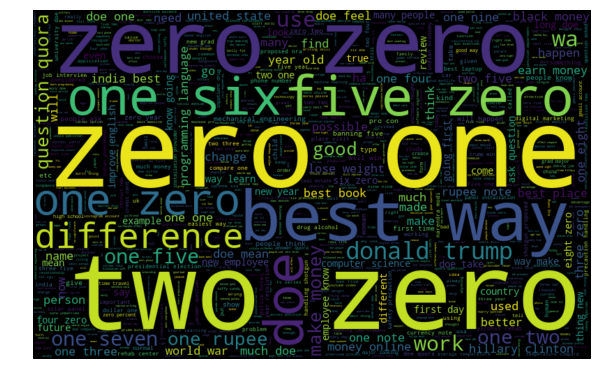

In [20]:
# gettings question1 and question2 into one array.
all_questions = np.dstack([data.question1, data.question2]).flatten()
all_questions = " ".join(all_questions)

plt.figure(figsize=(10,12))
wc = WordCloud(width=800, height=500, background_color="black", random_state=0, stopwords = STOPWORDS, max_words=len(all_questions)).generate(all_questions)
plt.imshow(wc,interpolation="bilinear")
plt.axis("off")
plt.show()

Well this are the most used words in questions. Lets plot different wordclouds for similar and non similar category 
as it will give us more insight

### WordCloud For Similar Questions

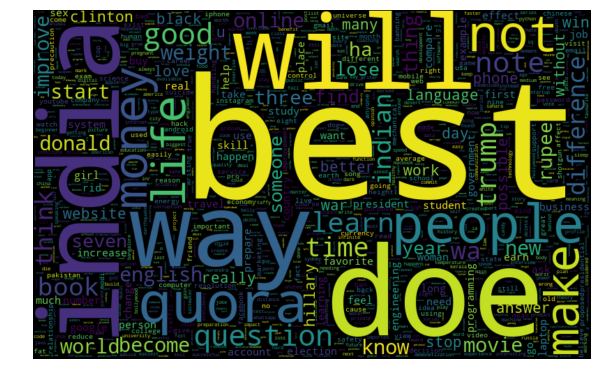

In [70]:
# gettings question1 and question2 into one array.
similar_que = data[["question1","question2"]][data.is_duplicate == 1]
similar_que = " ".join(np.dstack([similar_que.question1, similar_que.question2]).flatten())
similar_que = pd.Series(similar_que.split()).value_counts().drop("one").drop("zero").drop("two").drop("six").drop("five").drop("four")

# lets drop the stopwords
for i in similar_que.keys():
    if i in stopwords:
        similar_que = similar_que.drop(i)

plt.figure(figsize=(10,12))
wc = WordCloud(width=800, height=500, background_color="black", random_state=0, max_words=len(similar_que), stopwords=STOPWORDS).generate_from_frequencies(similar_que)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

The words with max size are the most frequent words used in similar questions

### WordCloud For Non Similar Questions

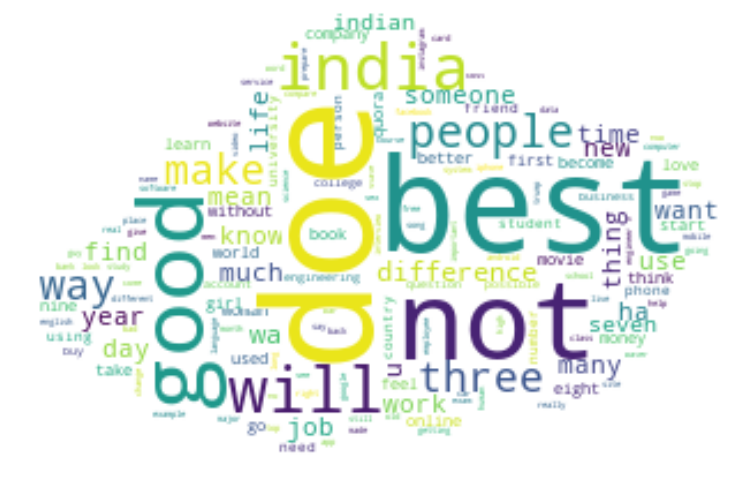

In [84]:
# gettings question1 and question2 into one array.
non_similar_que = " ".join(np.array(data[["question1","question2"]][data.is_duplicate == 0]).flatten())
non_similar_que = pd.Series(non_similar_que.split()).value_counts().drop("one").drop("zero").drop("two").drop("six").drop("five").drop("four")
# lets drop the stopwords
for i in non_similar_que.keys():
    if i in stopwords:
        non_similar_que = non_similar_que.drop(i)
        
## Lets give wordcloud a shape
mask = np.array(Image.open(requests.get(r'http://www.clker.com/cliparts/8/d/2/8/1258662140461877526jean_victor_balin_cloud.svg.med.png', stream=True).raw))

plt.figure(figsize=(10,12),facecolor = 'white', edgecolor='blue')
wc = WordCloud(width=800, height=500, background_color="white", random_state=0, max_words=len(non_similar_que), stopwords=STOPWORDS, mask = mask).generate_from_frequencies(non_similar_que)
plt.imshow(wc, interpolation='bilinear')
plt.tight_layout(pad=0)
plt.axis("off")
plt.show()

The words with max size are the most frequent words used in non similar questions

## 2] Bivariate Analysis - Plotting Pair Plot

#### 1) Pair_Plot_1

<Figure size 720x864 with 0 Axes>

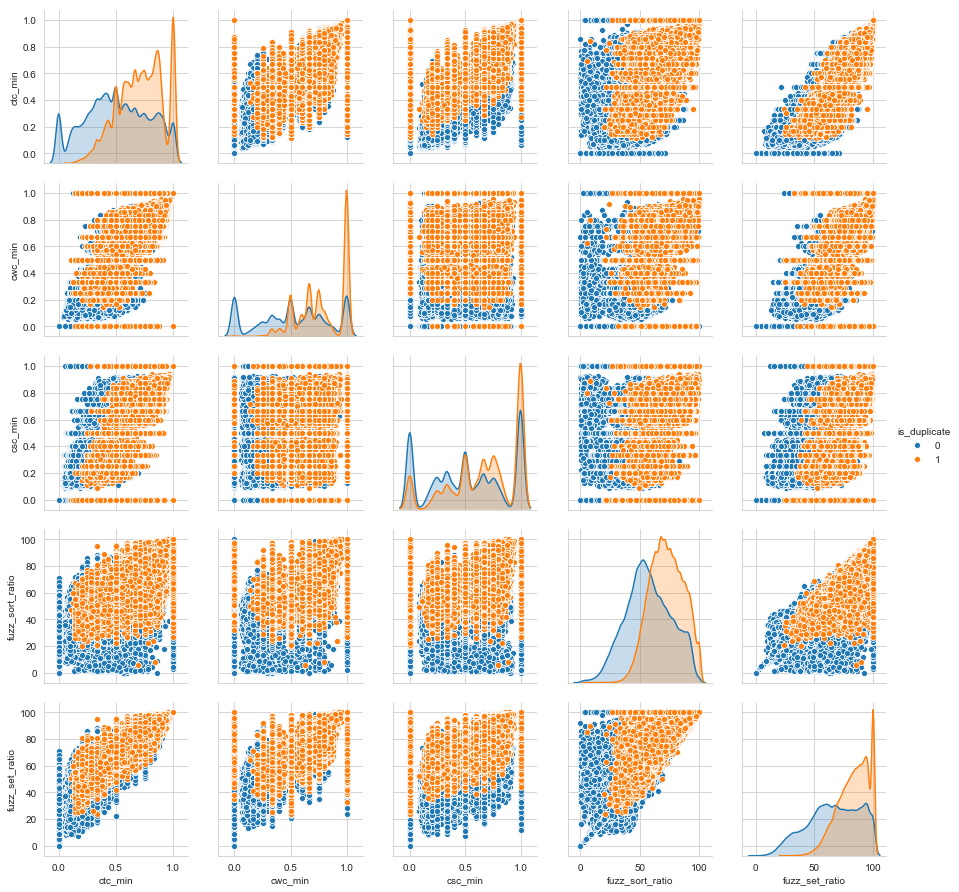

In [102]:
plt.figure(figsize=(10,12))
sns.set_style("whitegrid")
sns.pairplot(data[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio','token_set_ratio','is_duplicate']], hue="is_duplicate", vars=['ctc_min', 'cwc_min', 'csc_min', 'fuzz_sort_ratio','fuzz_set_ratio'])
plt.show()

Conclusion :-

1] The fuzz_sort_ratio vs csc_min seperates data well not enitirely but better than anyone else.

2] Also the fuzz_set_ratio vs csc_min seperates data well again not entiely but better than others.

Hence we will use those feature for univarite analysis. But first lets try some other combinations

#### 2) Pair_Plot_2 

<Figure size 720x864 with 0 Axes>

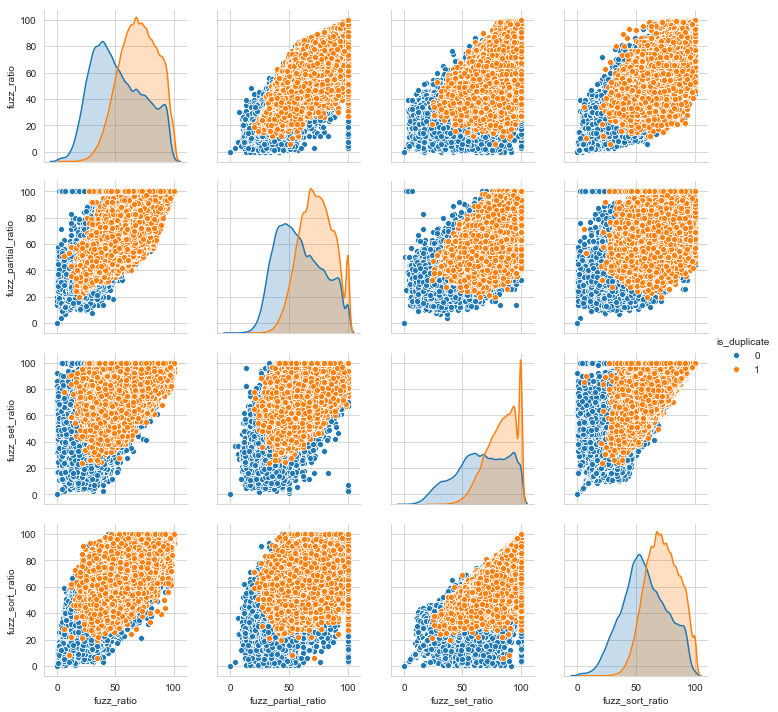

In [129]:
plt.figure(figsize=(10,12))
sns.set_style("whitegrid")
sns.pairplot(data[["fuzz_ratio","fuzz_partial_ratio","token_set_ratio","token_sort_ratio","is_duplicate"]], vars=["fuzz_ratio","fuzz_partial_ratio","fuzz_set_ratio","fuzz_sort_ratio"],hue="is_duplicate" )
plt.show()

## 3] Univariate Analysis using Violin & Pdf plot

#### Fuzz_sort_ratio 

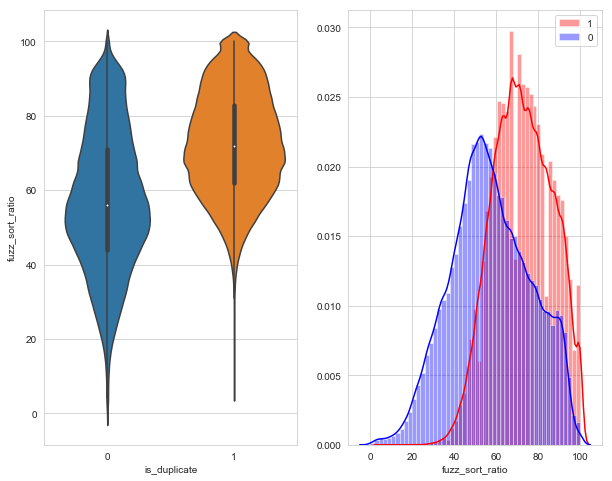

In [142]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.violinplot(y="token_sort_ratio", x="is_duplicate", data=data)

plt.subplot(1,2,2)
sns.set_style("whitegrid")
sns.distplot(data.fuzz_sort_ratio[data.is_duplicate==1], label="1", color="r")
sns.distplot(data.fuzz_sort_ratio[data.is_duplicate==0], label="0", color="b")
plt.legend()

plt.show()

#### Fuzz_set_ratio 

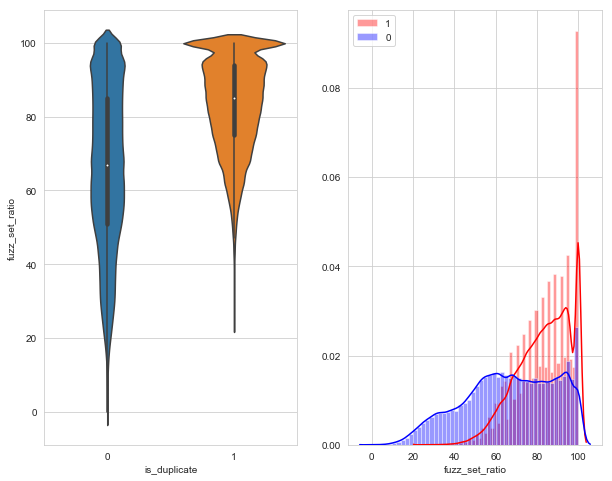

In [143]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.violinplot(x="is_duplicate", y="token_set_ratio", data=data)

plt.subplot(1,2,2)
sns.set_style("whitegrid")
sns.distplot(data.fuzz_set_ratio[data.is_duplicate ==1], label="1", color="r")
sns.distplot(data.fuzz_set_ratio[data.is_duplicate ==0], label="0", color="b")
plt.legend()
plt.show()

#### Fuzz_ratio 

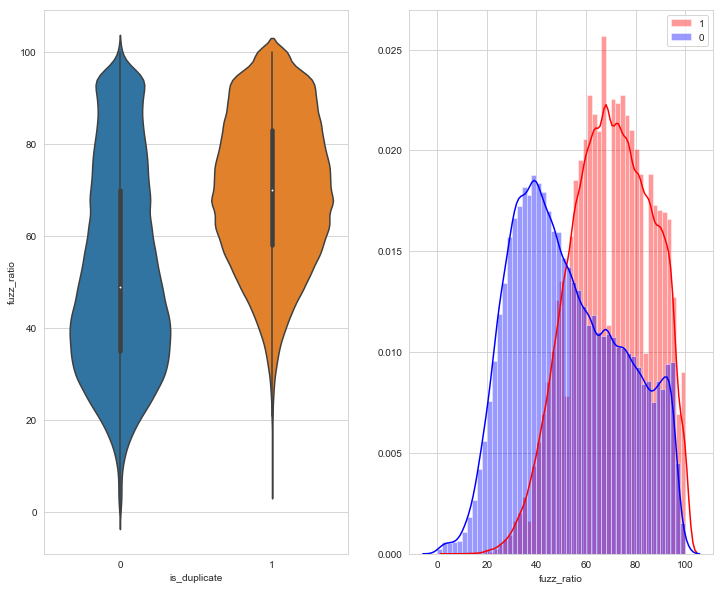

In [33]:
plt.figure(figsize=(12,10))

plt.subplot(1,2,1)
sns.violinplot(x="is_duplicate", y="fuzz_ratio", data=data)

plt.subplot(1,2,2)
sns.set_style("whitegrid")
sns.distplot(data.fuzz_ratio[data.is_duplicate ==1], label="1", color="r")
sns.distplot(data.fuzz_ratio[data.is_duplicate ==0], label="0", color="b")
plt.legend()
plt.show()

### 4] Data Visualization using TSNE

In [279]:
y = data.iloc[:,6:7].values
X = data.iloc[:,7:].values

In [160]:
# Nomalizing datasets for tsne
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
X = sc.fit_transform(X)


In [280]:
# Sampling 5000 points
X = X[:5000,:]
y = y[:5000,:]

In [281]:
y.shape

(5000, 1)

In [282]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components =2, perplexity =20, learning_rate=50, verbose=0, n_iter=1000,random_state=21)
tsne = tsne.fit_transform(X)

In [283]:
tsne.shape

(5000, 2)

In [284]:
y.shape

(5000, 1)

In [285]:
df = np.hstack([tsne,y])

In [286]:
df = pd.DataFrame(df, columns=["PC1", "PC2","is_duplicate"])

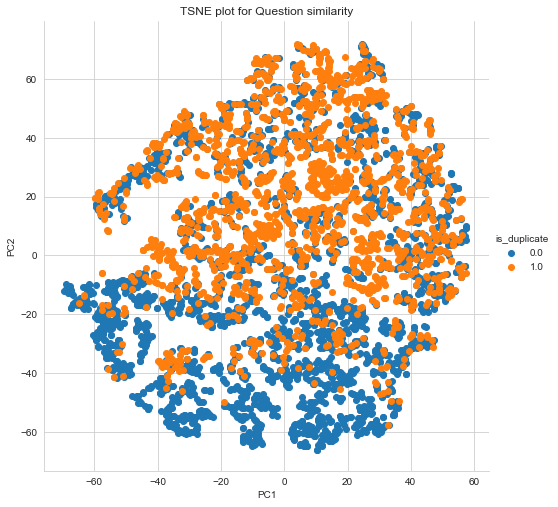

In [287]:
sns.set_style("whitegrid")
sns.FacetGrid(df, hue="is_duplicate", height=7).map(plt.scatter, "PC1","PC2").add_legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("TSNE plot for Question similarity")
plt.show()